In [1]:
import crocoddyl
import pinocchio
from IPython.display import HTML
import mim_solvers
import numpy as np
from matplotlib import animation
from matplotlib import pyplot as plt
from PointMass_model import DifferentialActionModelPointMass
from PointMass_utils import *

In [102]:
nr = 2

In [14]:
w_run = np.array([10., 1000.]) # {Trans, Obs}
w_term = np.array([1000., 1000.]) # {Trans, Obs}
w_des = np.hstack([w_run, w_term]).copy()
PM_DAM_running = DifferentialActionModelPointMass(w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
T = 50
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_opt = mim_solvers.SolverSQP(problem)
sqp_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_opt.with_callbacks=True
sqp_opt.termination_tolerance = 5e-4
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_opt.solve(xs_init, us_init, 100)
xs_optimal = np.stack(sqp_opt.xs.tolist().copy())
us_optimal = np.stack(sqp_opt.us.tolist().copy())
print(done)

iter     merit         cost         grad      step    ||gaps||        KKT
   1  5.12543e+04  5.12543e+04  1.77525e+01  1.0000  0.00000e+00  9.94673e+03
   2  8.81123e+03  8.81123e+03  9.61425e-03  1.0000  1.23235e-14  8.81516e+01
   3  8.78890e+03  8.78890e+03  1.26822e-01  1.0000  1.72873e-11  2.64181e+03
   4  8.59825e+03  8.59825e+03  9.67186e-02  1.0000  1.30279e-10  1.97337e+02
   5  8.45665e+03  8.45665e+03  9.74208e-02  1.0000  1.30549e-10  3.16290e+02
   6  8.32924e+03  8.32924e+03  1.03209e-01  1.0000  1.10821e-10  4.38395e+02
   7  8.19429e+03  8.19429e+03  1.11720e-01  1.0000  9.38199e-11  4.53463e+02
   8  8.03425e+03  8.03425e+03  1.18265e-01  1.0000  1.05887e-10  4.54745e+02
   9  7.84637e+03  7.84637e+03  1.20861e-01  1.0000  1.10638e-10  4.06497e+02
  10  7.63933e+03  7.63933e+03  2.58406e+00  1.0000  9.72637e-11  6.28079e+03
iter     merit         cost         grad      step    ||gaps||        KKT
  11  3.40889e+03  3.40889e+03  1.89768e+00  1.0000  4.95180e-10  5.3844

In [ ]:
HTML(animatePointMass(xs_optimal).to_jshtml())

In [16]:
# Run again with bad weights (zero for obstacles)
w_run = np.array([10., 0.]) # {Trans, Obs}
w_term = np.array([1000., 0.])
w_bad = np.hstack([w_run, w_term]).copy()
PM_DAM_running = DifferentialActionModelPointMass(w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
T = 50
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp_non_opt = mim_solvers.SolverSQP(problem)
sqp_non_opt.setCallbacks([crocoddyl.CallbackVerbose()])
sqp_non_opt.with_callbacks=True
sqp_non_opt.termination_tolerance = 5e-4
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp_non_opt.solve(xs_init, us_init, 100)
print(done)
xs_non_optimal = sqp_non_opt.xs.copy()
us_non_optimal = sqp_non_opt.us.copy()

iter     merit         cost         grad      step    ||gaps||        KKT
   1  5.12500e+04  5.12500e+04  1.84311e+01  1.0000  0.00000e+00  9.98278e+03
   2  5.20015e+02  5.20015e+02  1.87564e-05  1.0000  1.78746e-14  1.68997e-03
True
 END  5.20015e+02  5.20015e+02  1.46809e-06   ----   7.54915e-14  1.47982e-07


In [ ]:
HTML(animatePointMass(xs_non_optimal).to_jshtml())

In [18]:
print('Desired Trajectory Cost:  ', traj_cost(xs_optimal, us_optimal, w_des[:2], w_des[2:], timeStep), ' || other Trajectory, same cost:   ', traj_cost(xs_non_optimal, us_non_optimal, w_des[:2], w_des[2:], timeStep))
print('Bad Trajectory Cost:      ', traj_cost(xs_non_optimal, us_non_optimal, w_bad[:2], w_bad[2:], timeStep), ' || other Trajectory, same cost:   ', traj_cost(xs_optimal, us_optimal, w_bad[:2], w_bad[2:], timeStep))

Desired Trajectory Cost:   714.4311809301132  || other Trajectory, same cost:    3140.962662645165
Bad Trajectory Cost:       152.67893013665528  || other Trajectory, same cost:    172.08861970655812


In [127]:
###### IRL #######

In [95]:
# generating bad trajectories
num_bad = 5
xs_non_optimal_set = []
us_non_optimal_set = []
xs_non_optimal_set.append(np.stack(xs_non_optimal.tolist()).copy())
us_non_optimal_set.append(np.stack(us_non_optimal.tolist()).copy())
for _ in range(num_bad):
    Us = us_non_optimal.copy()+np.random.normal(0,0.01,np.stack(us_non_optimal.tolist()).shape)
    Xs = xs_non_optimal.copy()+np.random.normal(0,0.01,np.stack(xs_non_optimal.tolist()).shape)
    us_non_optimal_set.append(Us)
    xs_non_optimal_set.append(Xs)

In [134]:
for X, U in zip(xs_non_optimal_set, us_non_optimal_set):
    print(np.exp(-traj_cost(X,U,w_bad[:nr], w_bad[nr:], dt)))

4.9247380921237845e-67
3.33104652569242e-66
2.187998588368519e-66
1.4330635241992866e-67
2.25438335437083e-79
3.507002383005448e-74


In [100]:
# generating good trajectories
num_good = 5
xs_optimal_set = []
us_optimal_set = []
xs_optimal_set.append(np.stack(xs_optimal.tolist()).copy())
us_optimal_set.append(np.stack(us_optimal.tolist()).copy())
for _ in range(num_good):
    Us = us_optimal.copy()+np.random.normal(0,0.01,np.stack(us_optimal.tolist()).shape)
    Xs = xs_optimal.copy()+np.random.normal(0,0.01,np.stack(xs_optimal.tolist()).shape)
    us_optimal_set.append(Us)
    xs_optimal_set.append(Xs)

In [135]:
for X, U in zip(xs_optimal_set, us_optimal_set):
    print(np.exp(-traj_cost(X,U,w_bad[:nr], w_bad[nr:], dt)))

1.8317325507178892e-75
8.692299051823508e-84
5.397590181122602e-85
5.2835671850972327e-76
1.0669057385710892e-75
3.358503482950852e-78


In [136]:
# IRL Algorithm
from scipy.optimize import minimize
from scipy.optimize import Bounds
nr = 2
def fcn_w(x, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    output = 0
    num = 1e-100
    den = 1e-100
    num += np.exp(-traj_cost(xs_optimal, us_optimal, x[:nr], x[nr:], dt))
    den += num
    for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
        den += np.exp(-traj_cost(Xs, Us, x[:nr], x[nr:], dt))

    output -= np.log(num/den)
    output += Lambda*np.linalg.norm(x)
    return output

def fcn_w_nD(x, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda = 0.001):
    output = 0
    for Xs_opt, Us_opt in zip(xs_optimal_set, us_optimal_set):
        num = 1e-100
        den = 1e-100
        num += np.exp(-traj_cost(Xs_opt, Us_opt, x[:nr], x[nr:], dt))
        den += num
        for Xs, Us in zip(xs_non_optimal_set, us_non_optimal_set):
            den += np.exp(-traj_cost(Xs, Us, x[:nr], x[nr:], dt))
        output -= np.log(num/den)
    
    output += Lambda*np.linalg.norm(x)
    return output



In [137]:
dt = timeStep
# dt = 1
Lambda = 0.0
lb = 0; ub = np.inf
bnds = Bounds(lb, ub)
options = {'maxiter': 100, 'iprint': -1,'ftol': 1e-10 ,'gtol' : 1e-10}
tol = 1e-10
x0 = w_bad
# x0 = np.array([1000, 1000, 1000, 1000])
res_1D = minimize(fcn_w, 
               x0, 
               args=(xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_1D)
w_irl_1D = res_1D.x

res_nD = minimize(fcn_w_nD, 
               x0, 
               args=(xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda), 
               bounds=bnds, 
               method='L-BFGS-B', 
               tol = tol,
               options=options)

print(res_nD)
w_irl_nD = res_nD.x

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 0.6931471805599453
        x: [ 7.691e+00  2.077e+03  9.630e+02  9.033e-05]
      nit: 2
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 35
     njev: 7
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 3.4640934570576484e-10
        x: [ 6.899e-01  1.921e+01  9.999e+02  0.000e+00]
      nit: 13
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
     nfev: 115
     njev: 23
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>


In [138]:
print('Desired: ')
print('Running ==> Translation:{}  Obstacle:{} '.format(w_des[0], w_des[1]))
print('Terminal ==> Translation:{}  Obstacle:{} '.format(w_des[2], w_des[3]))
print('Bad: ')
print('Running ==> Translation:{}  Obstacle:{} '.format(w_bad[0], w_bad[1]))
print('Terminal ==> Translation:{}  Obstacle:{} '.format(w_bad[2], w_bad[3]))
print('IRL 1-D: ')
print('Running ==> Translation:{}  Obstacle:{} '.format(w_irl_1D[0], w_irl_1D[1]))
print('Terminal ==> Translation:{}  Obstacle:{} '.format(w_irl_1D[2], w_irl_1D[3]))
print('IRL N-D: ')
print('Running ==> Translation:{}  Obstacle:{} '.format(w_irl_nD[0], w_irl_nD[1]))
print('Terminal ==> Translation:{}  Obstacle:{} '.format(w_irl_nD[2], w_irl_nD[3]))

Desired: 
Running ==> Translation:10.0  Obstacle:1000.0 
Terminal ==> Translation:1000.0  Obstacle:1000.0 
Bad: 
Running ==> Translation:10.0  Obstacle:0.0 
Terminal ==> Translation:1000.0  Obstacle:0.0 
IRL 1-D: 
Running ==> Translation:7.690763802520842  Obstacle:2076.8655357803955 
Terminal ==> Translation:963.0499928847815  Obstacle:9.032611177338656e-05 
IRL N-D: 
Running ==> Translation:0.6898661269494755  Obstacle:19.20935469418356 
Terminal ==> Translation:999.9053911028436  Obstacle:0.0 


In [139]:
print('Desired Trajectory Cost: ', traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL (1D) Weight:  ', traj_cost(xs_optimal, us_optimal, w_irl_1D[:nr], w_irl_1D[nr:], timeStep))
print('Bad Trajectory Cost:     ', traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL (1D) Weight:  ', traj_cost(xs_non_optimal, us_non_optimal, w_irl_1D[:nr], w_irl_1D[nr:], timeStep))

Desired Trajectory Cost:  714.4311809301132  || with IRL (1D) Weight:   1157.7600441128438
Bad Trajectory Cost:      152.67893013665528  || with IRL (1D) Weight:   6221.832505671057


In [140]:
print('Desired Trajectory Cost: ', traj_cost(xs_optimal, us_optimal, w_des[:nr], w_des[nr:], timeStep), ' || with IRL (ND) Weight:  ', traj_cost(xs_optimal, us_optimal, w_irl_nD[:nr], w_irl_nD[nr:], timeStep))
print('Bad Trajectory Cost:     ', traj_cost(xs_non_optimal, us_non_optimal, w_bad[:nr], w_bad[nr:], timeStep), ' || with IRL (ND) Weight:  ', traj_cost(xs_non_optimal, us_non_optimal, w_irl_nD[:nr], w_irl_nD[nr:], timeStep))

Desired Trajectory Cost:  714.4311809301132  || with IRL (ND) Weight:   36.697206645618024
Bad Trajectory Cost:      152.67893013665528  || with IRL (ND) Weight:   83.01201526091626


In [141]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w(w_des, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL 1D Fcn:     ', fcn_w(w_irl_1D, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w(w_bad, xs_optimal, us_optimal, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     0.6931471805599453
IRL 1D Fcn:      0.6931471805599453
Bad Fcn:         21.935239946802998


In [142]:
# Test IRL 1D Output
print('Desired Fcn:    ', fcn_w_nD(w_des, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('IRL ND Fcn:     ', fcn_w_nD(w_irl_nD, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))
print('Bad Fcn:        ', fcn_w_nD(w_bad, xs_optimal_set, us_optimal_set, xs_non_optimal_set, us_non_optimal_set, dt, Lambda))

Desired Fcn:     4.1588830833596715
IRL ND Fcn:      3.4640934570576484e-10
Bad Fcn:         180.80795851845315


In [147]:
# w_irl = w_irl_1D
w_irl = w_irl_nD

In [148]:
# Run again with bad weights (zero for obstacles)
w_run = w_irl[:nr].copy()
w_term = w_irl[nr:].copy()

PM_DAM_running = DifferentialActionModelPointMass(w_run)
PM_DAM_terminal = DifferentialActionModelPointMass(w_term)
pmDataRunning = PM_DAM_running.createData()
pmDataTerminal = PM_DAM_terminal.createData()
PM_ND_R = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_running, False)
PM_ND_T = crocoddyl.DifferentialActionModelNumDiff(PM_DAM_terminal, False)
timeStep = 5e-2
PM_IAM = crocoddyl.IntegratedActionModelEuler(PM_ND_R, timeStep)
PM_IAM_T = crocoddyl.IntegratedActionModelEuler(PM_ND_T, 0.0)
x0 = np.array([0.0, 0.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0])
T = 50
problem = crocoddyl.ShootingProblem(x0, [PM_IAM] * T, PM_IAM_T)
# Creating the SQP solver
sqp = mim_solvers.SolverSQP(problem)
sqp.setCallbacks([crocoddyl.CallbackVerbose()])
sqp.with_callbacks=True
sqp.termination_tolerance = 5e-4
xs_init = [x0 for i in range(T+1)]
us_init = [u0 for i in range(T)]

# Solving this problem
done = sqp.solve(xs_init, us_init, 100)
xs_output = np.stack(sqp.xs.tolist().copy())
us_output = np.stack(sqp.us.tolist().copy())

iter     merit         cost         grad      step    ||gaps||        KKT
   1  5.00816e+04  5.00816e+04  1.79825e+01  1.0000  0.00000e+00  9.99714e+03
   2  1.50793e+02  1.50793e+02  6.78036e-02  1.0000  1.16573e-14  1.40031e+01
   3  1.49382e+02  1.49382e+02  5.78483e-02  1.0000  1.52579e-10  3.91405e+00
   4  1.48397e+02  1.48397e+02  5.23177e-02  1.0000  1.72000e-10  1.12009e+00
   5  1.47575e+02  1.47575e+02  4.84376e-02  1.0000  1.41837e-10  9.73311e-01
   6  1.46859e+02  1.46859e+02  4.53707e-02  1.0000  1.70496e-10  8.64693e-01
   7  1.46226e+02  1.46226e+02  4.27282e-02  1.0000  1.48592e-10  7.76712e-01
   8  1.45663e+02  1.45663e+02  4.04482e-02  1.0000  1.11939e-10  7.54832e-01
   9  1.45159e+02  1.45159e+02  3.83976e-02  1.0000  1.37202e-10  7.17042e-01
  10  1.44703e+02  1.44703e+02  3.65489e-02  1.0000  1.10312e-10  6.67590e-01
iter     merit         cost         grad      step    ||gaps||        KKT
  11  1.44290e+02  1.44290e+02  3.48882e-02  1.0000  1.17735e-10  6.1663

In [149]:
print(traj_cost(xs_output, us_output, w_irl[:nr], w_irl[nr:], dt))

25.783941133027408


processing the animation ... 
... processing done


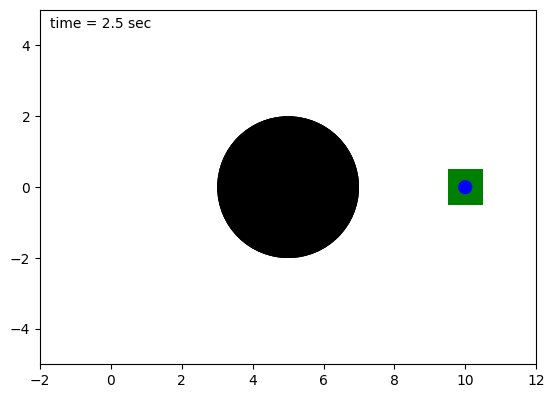

In [151]:
HTML(animatePointMass(xs_output).to_jshtml())

In [240]:
print('Optimal Solver Cost:     ', sqp_opt.cost)
print('Non-Optimal Solver Cost: ', sqp_non_opt.cost)
print('IRL Solver Cost:         ', sqp.cost)

Optimal Solver Cost:      739.0768908583627
Non-Optimal Solver Cost:  520.014719755544
IRL Solver Cost:          22.4877389220481
